<a href="https://colab.research.google.com/github/dimasprd/College-Final-Project/blob/main/001_AI_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install segypy
import segypy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score, max_error, mean_squared_error, mean_pinball_loss

import warnings

warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 200
plt.style.use('seaborn')

from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# load the dataset

dataset_F032 = pd.read_excel('/content/drive/My Drive/Final Project/Well-F032.xlsx')
dataset_F021 = pd.read_excel('/content/drive/My Drive/Final Project/Well-F021.xlsx')
dataset_F061 = pd.read_excel('/content/drive/My Drive/Final Project/Well-F061.xlsx')

In [3]:
# set the data range

data_F032 = dataset_F032[dataset_F032[dataset_F032['twt']==430.076].index[0] :
                         dataset_F032[dataset_F032['twt']==926.986].index[0]]

data_F021 = dataset_F021[dataset_F021[dataset_F021['twt']==481.11].index[0] :
                         dataset_F021[dataset_F021['twt']==1103.946].index[0]]

data_F061 = dataset_F061[dataset_F061[dataset_F061['twt']==649.854].index[0] :
                         dataset_F061[dataset_F061['twt']==1087.04].index[0]]

In [4]:
def normalize(data, data_norm=None, normalize=True):
    '''
    to normalize data
    
    params:
    
    data: data to normalize. should in 2d array
    data_norm: data to unnormalize.
    normalize: (True, False). if True, data will be normalize and "data_norm" param is unnecessary
    if False, "data_norm" is the data to be normalize and "data" param is necessary
    '''
    min_val = min(data.values.flatten())
    max_val = max(data.values.flatten())
    
    if normalize:
        return (data - min_val)/(max_val - min_val)
    else:
        return data_norm*(max_val - min_val) + min_val

    
def scaling_col_values(data, min_val=None, max_val=None):
    '''
    function to normalize certain column values in DataFrame
    '''
    return (data - min_val)/(max_val - min_val)


def scaling_df_values(df):
    '''
    function to normalize all columns values in DataFrame
    '''
    df_scaled = df.copy()
    for i in range(len(df_scaled.columns)):
        min_val = min(df_scaled[df_scaled.columns[i]])
        max_val = max(df_scaled[df_scaled.columns[i]])
        df_scaled[df_scaled.columns[i]] = scaling_col_values(
            df_scaled[df_scaled.columns[i]], min_val=min_val, max_val=max_val
        )
    return df_scaled


def absolute_error(actual_data, prediction_data):
    '''
    function to calculate absolute error
    '''
    return abs(actual_data - prediction_data)


def load_data(data):
    '''
    function to load seismic data
    '''
    read = segypy.readSegy(data)
    return read[0]


def filter(df, order=5, cutoff=10, fs=1000/2):
    df_filt = df.apply(
      lambda data: filtfilt(
          butter(order, (cutoff / (0.5 * fs)), btype='low', analog=False)[0], 
          butter(order, (cutoff / (0.5 * fs)), btype='low', analog=False)[1],
          data
          )
      )
    return df_filt

In [5]:
# transform pwave respect to impedance

lf_ai_032 = data_F032['ai_model']
lf_ai_021 = data_F021['ai_model']
lf_ai_061 = data_F061['ai_model']

lf_pw_032 = data_F032['pw_model']
lf_pw_021 = data_F021['pw_model']
lf_pw_061 = data_F061['pw_model']

lf_pw_032_norm = normalize(lf_pw_032)
lf_pw_021_norm = normalize(lf_pw_021)
lf_pw_061_norm = normalize(lf_pw_061)

lf_pw_032_ai = normalize(
    lf_ai_032, data_norm = lf_pw_032_norm, normalize=False
)
lf_pw_021_ai = normalize(
    lf_ai_021, data_norm = lf_pw_021_norm, normalize=False
)
lf_pw_061_ai = normalize(
    lf_ai_032, data_norm = lf_pw_061_norm, normalize=False
)

In [6]:
# assign pw2ai to a new column 

data_F032['pw2ai_model'] = lf_pw_032_ai
data_F021['pw2ai_model'] = lf_pw_021_ai
data_F061['pw2ai_model'] = lf_pw_061_ai

In [7]:
# set features and target

features = [
            'pw_model', 'amp_env', 'amp_wgh_cos_phase',
            'int_abs_amp', 'deriv_inst_amp', 'quad'
]
target = ['true_ai']

In [8]:
training_wells = [data_F032, data_F021]
testing_wells = [data_F061]

training_wells_comp = pd.concat(training_wells)
training_wells_comp = training_wells_comp.sample(frac=1)

testing_well_comp = testing_wells[0]

X_train = training_wells_comp[features]
y_train = training_wells_comp[target]

X_test = testing_well_comp[features]
y_test = testing_well_comp[target]

In [9]:
# scale the data

scaler_x = preprocessing.MinMaxScaler(feature_range=(0,1))
scaler_x.fit(X_train)
X_train_scaled = scaler_x.transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

scaler_y = preprocessing.MinMaxScaler(feature_range=(0,1)).fit(y_train)
y_train_scaled = scaler_y.transform(y_train) 
y_test_scaled = scaler_y.transform(y_test)

In [10]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)
y_train_scaled = pd.DataFrame(y_train_scaled, columns = y_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns)
y_test_scaled = pd.DataFrame(y_test_scaled, columns = y_test.columns)

# Gradient Boosting

In [11]:
model_gb = GradientBoostingRegressor(
    learning_rate=0.2,
    max_depth=9,
    min_samples_leaf=2,
    min_samples_split=7,
    n_estimators=500,
).fit(X_train_scaled, y_train_scaled)

# prediction
pred_gb_scaled = model_gb.predict(X_test_scaled)

# inverse transform
pred_gb_scaled = pred_gb_scaled.reshape((pred_gb_scaled.shape[0], 1))
pred_gb = scaler_y.inverse_transform(pred_gb_scaled)
pred_gb = np.array(pred_gb)

# save prediction result
np.save('/content/drive/My Drive/Final Project/Prediction Results/pred_gb', pred_gb)

# create to DataFrame
pred_gb_df = pd.DataFrame({'GB prediction': pred_gb.flatten()})

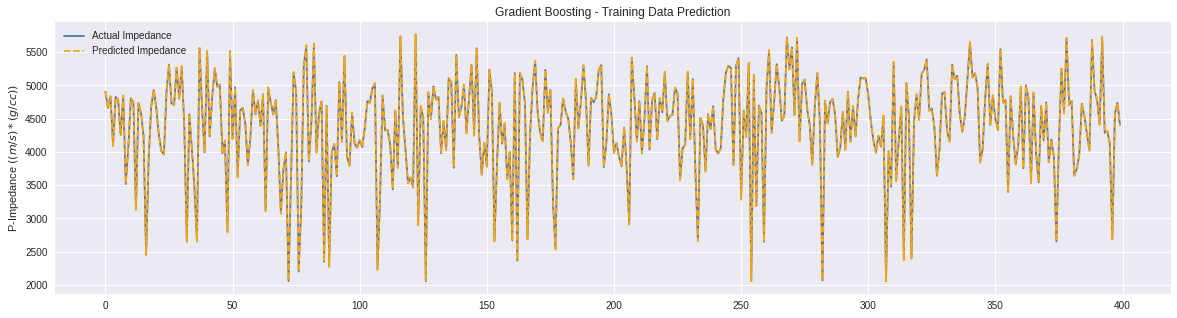

In [12]:
# prediction on training data
pred_train_gb_scaled = model_gb.predict(X_train_scaled)
temp1 = pred_train_gb_scaled.reshape((pred_train_gb_scaled.shape[0], 1))
pred_train_gb = scaler_y.inverse_transform(temp1)
pred_train_gb = np.array(pred_train_gb)

plt.figure(figsize = (20,5))
plt.plot(y_train.values[100:500], label = "Actual Impedance")
plt.plot(pred_train_gb[100:500], "--", color = "orange", label = "Predicted Impedance")

plt.title('Gradient Boosting - Training Data Prediction')
plt.ylabel("P-Impedance $((m/s)*(g/cc))$")
plt.legend()
plt.show()

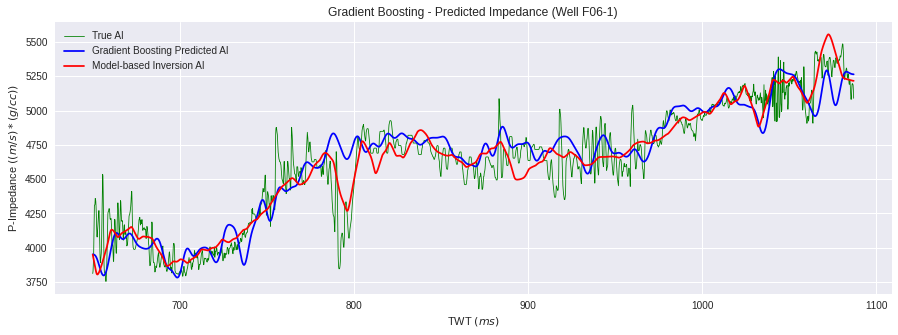

In [13]:
# prediction on test data
plt.figure(figsize = (15,5))
plt.plot(data_F061['twt'], y_test, color='g', linewidth=0.8, label = "True AI")
plt.plot(data_F061['twt'], filter(pred_gb_df), "-", color = "b", label = "Gradient Boosting Predicted AI")
plt.plot(data_F061['twt'], data_F061['mbi'], color='red', label = "Model-based Inversion AI")

plt.title('Gradient Boosting - Predicted Impedance (Well F06-1)')
plt.xlabel("TWT $(ms)$")
plt.ylabel("P-Impedance $((m/s)*(g/cc))$")
plt.legend()

plt.show()

In [14]:
metrics_df = pd.DataFrame({
    "MAE" : [mean_absolute_error(y_test, data_F061['mbi']), mean_absolute_error(y_test, pred_gb)],
    "R2"  : [r2_score(y_test, data_F061['mbi']), r2_score(y_test, pred_gb)],
    "ME"  : [max_error(y_test, data_F061['mbi']), max_error(y_test, pred_gb)],
    "MSE" : [mean_squared_error(y_test, data_F061['mbi'], squared=True), mean_squared_error(y_test, pred_gb, squared=True)],
    "RMSE" : [mean_squared_error(y_test, data_F061['mbi'], squared=False), mean_squared_error(y_test, pred_gb, squared=False)]
})

metrics_df.index = ['Model-based', 'Gradient-Boosting']
metrics_df

,MAE,R2,ME,MSE,RMSE
Model-based,98.066380,0.894347,635.667500,17531.451699,132.406388
Gradient-Boosting,132.660252,0.801432,976.429343,32949.378510,181.519637


# Extreme Gradient Boosting (XGBoost)

# Category Boosting (CatBoost)

# Light Gradient Boosting Machine (LightGBM)

# Long-Short Term Memory (LSTM)